# SNGP Tutorial
[Spectral Normalized Gaussian Process (SNGP) Classification](https://lightning-uq-box.readthedocs.io/en/latest/tutorials/classification/sngp.html)


In [12]:
import os
import tempfile

import torch
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.uq_methods import SNGPClassification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_training_metrics,
    plot_two_moons_data,
)

# Configure tmp dir for logs and checkpoints
tmp_dir = '/workspace/logs/tmp'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_everything(2)

Seed set to 2


2

# Datamodule

In [3]:
dm = TwoMoonsDataModule(batch_size=128)


In [4]:
# define data
X_train, y_train, X_test, y_test, test_grid_points = (
    dm.X_train,
    dm.y_train,
    dm.X_test,
    dm.y_test,
    dm.test_grid_points,
)

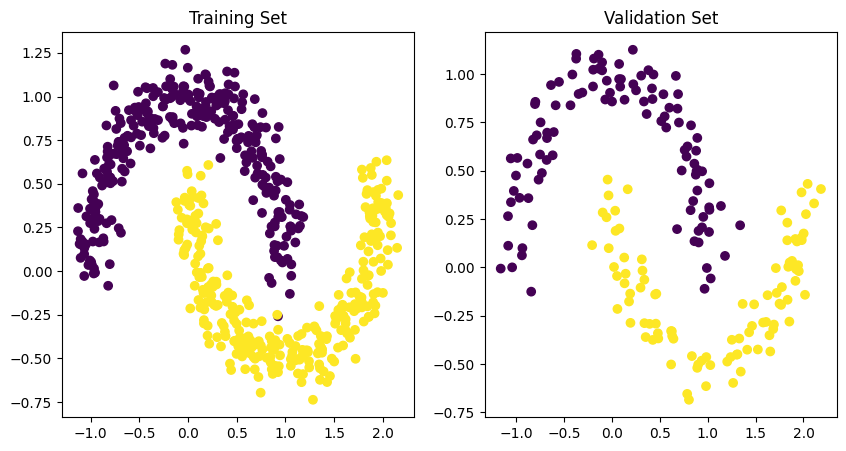

In [5]:
fig = plot_two_moons_data(X_train, y_train, X_test, y_test)


# Model

In [6]:
feature_extractor = FCResNet(input_dim=2, features=64, depth=4)


In [9]:
sngp = SNGPClassification(
    feature_extractor=feature_extractor,
    loss_fn=torch.nn.CrossEntropyLoss(),
    num_targets=2,
)

# Trainer

In [7]:
logger = CSVLogger(tmp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=tmp_dir,
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(sngp, dm)


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /workspace/logs/tmp/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                  | Params
------------------------------------------------------------
0 | feature_extractor | FCResNet              | 16.8 K
1 | loss_fn           | CrossEntropyLoss      | 0     
2 | normalize         | LayerNorm             | 256   
3 | rff               | RandomFourierFeatures | 0     
4 | beta              | Linear                | 2.0 K 
5 | train_metrics     | MetricCollection      | 0     
6 | val_metrics       | MetricCollection      | 0     
7 | test_metrics      | Metr

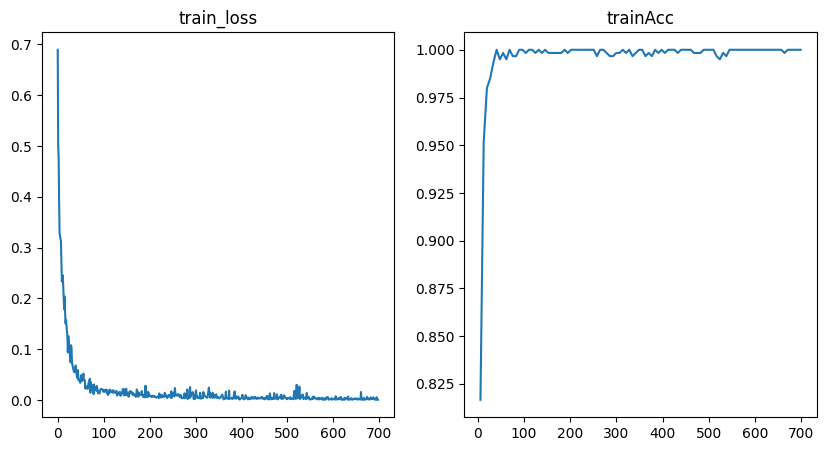

In [13]:
fig = plot_training_metrics(
    os.path.join(tmp_dir, "lightning_logs"), ["train_loss", "trainAcc"]
)

# Predictions

In [14]:
preds = sngp.predict_step(test_grid_points)


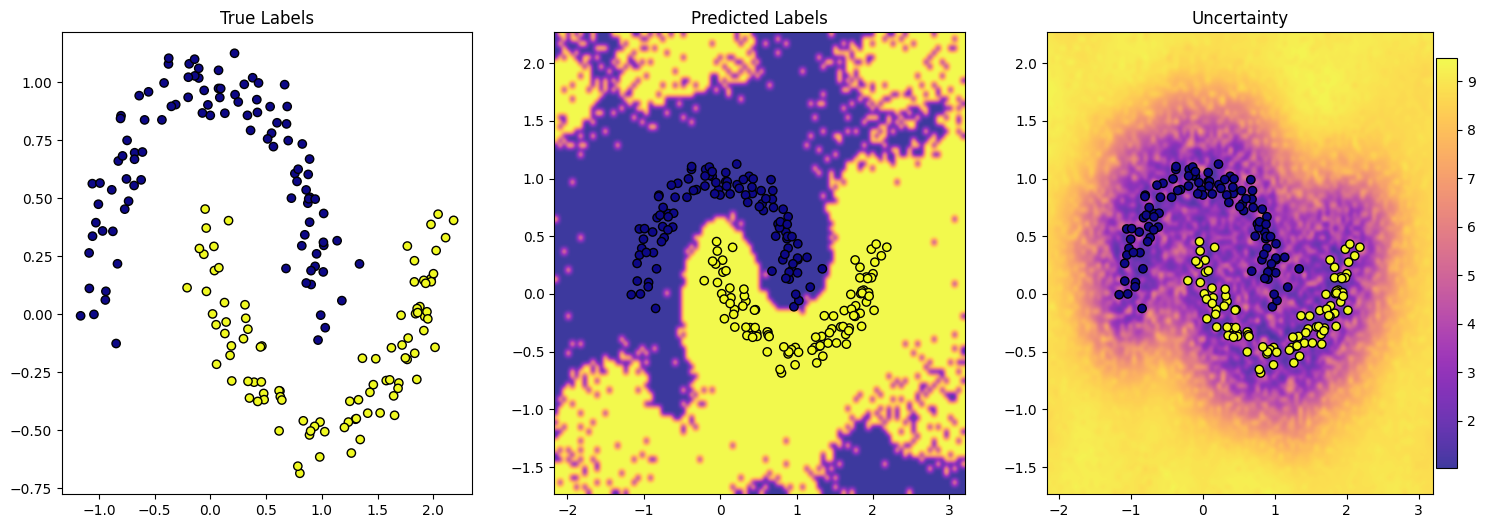

In [15]:
fig = plot_predictions_classification(
    X_test,
    y_test,
    preds["pred"].argmax(-1),
    test_grid_points,
    preds["pred_uct"].cpu().numpy(),
)